In [2]:
from astropalmerio.mc import utils
from astropalmerio.mc.sampling import sample_asym_norm
from astropalmerio.mc.realizations import MC_realization
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)
ROOT_DIR = Path('/Users/palmerio/Code_projects/astropalmerio/dev/')
plt.style.use('paper')
plt.style.use('kraken')

## Practical example: propagating measurement uncertainty with Monte Carlo

For the purpose of this example, we will be studying a distant galaxy for which we have obtained an optical spectrum.
This has allowed us to measure the fluxes of the $H\alpha$ and $H\beta$ emission lines, yielding the following result:

- $F_{H\alpha} = (30 \pm 5) \times 10^{-18}$ erg/cm2/s
- $F_{H\beta} = (15 \pm 5) \times 10^{-18}$ erg/cm2/s

The errors here are due solely to measurement uncertainty, which is a random process that we assume to yield gaussian errors (we will neglect systematic errors for the purpose of this example).


We would like to estimate the ratio of these fluxes, which is something we can use to derive how much attenuation there is due to dust extinction in this galaxy (let us assume there is no dust from our own Galaxy along the line of sight).
We can compute the ratio with Monte Carlo sampling with the following:

In [4]:
F_Ha = 30.
F_Ha_unc = 5.
F_Hb = 15.
F_Hb_unc = 5.

F_Ha_draw = MC_realization(data=F_Ha,
                           uncp=F_Ha_unc)

F_Hb_draw = MC_realization(data=F_Hb,
                           uncp=F_Hb_unc)

In [5]:
def show_Ha_Hb(F_Ha, F_Ha_uncp, F_Hb, F_Hb_uncp, F_Ha_draw, F_Hb_draw, F_Ha_uncm=None, F_Hb_uncm=None):
    ratio = F_Ha_draw/F_Hb_draw
    if F_Ha_uncm is None:
        F_Ha_uncm = F_Ha_uncp
    if F_Hb_uncm is None:
        F_Hb_uncm = F_Hb_uncp
    fig, axes = plt.subplots(2, tight_layout=True)
    ax0 = axes[0]
    ax1 = axes[1]
    ax0.hist(F_Ha_draw, density=True, label=r'$H_\alpha$', alpha=0.8, color='C1')
    ax0.axvline(F_Ha, color='C1')
    ax0.axvline(F_Ha+F_Ha_uncp, ls='--', lw=1, color='C1')
    ax0.axvline(F_Ha-F_Ha_uncm, ls='--', lw=1, color='C1')
    ax0.hist(F_Hb_draw, density=True, label=r'$H_\beta$', alpha=0.8, color='C3')
    ax0.axvline(F_Hb, color='C3')
    ax0.axvline(F_Hb+F_Hb_uncp, ls='--', lw=1, color='C3')
    ax0.axvline(F_Hb-F_Hb_uncm, ls='--', lw=1, color='C3')
    ax0.set_xlabel(r'Flux [$\rm 10^{-18}~erg/s/cm^2$]')
    ax1.set_xlabel(r'$\rm H_{\alpha}/H_{\beta}$ ratio')

    ax0.legend()
    ax1.hist(ratio, bins=np.linspace(0,10,50), density=True)
    return fig, axes

(<Figure size 1000x800 with 2 Axes>,
 array([<AxesSubplot: xlabel='Flux [$\\rm 10^{-18}~erg/s/cm^2$]'>,
        <AxesSubplot: xlabel='$\\rm H_{\\alpha}/H_{\\beta}$ ratio'>],
       dtype=object))

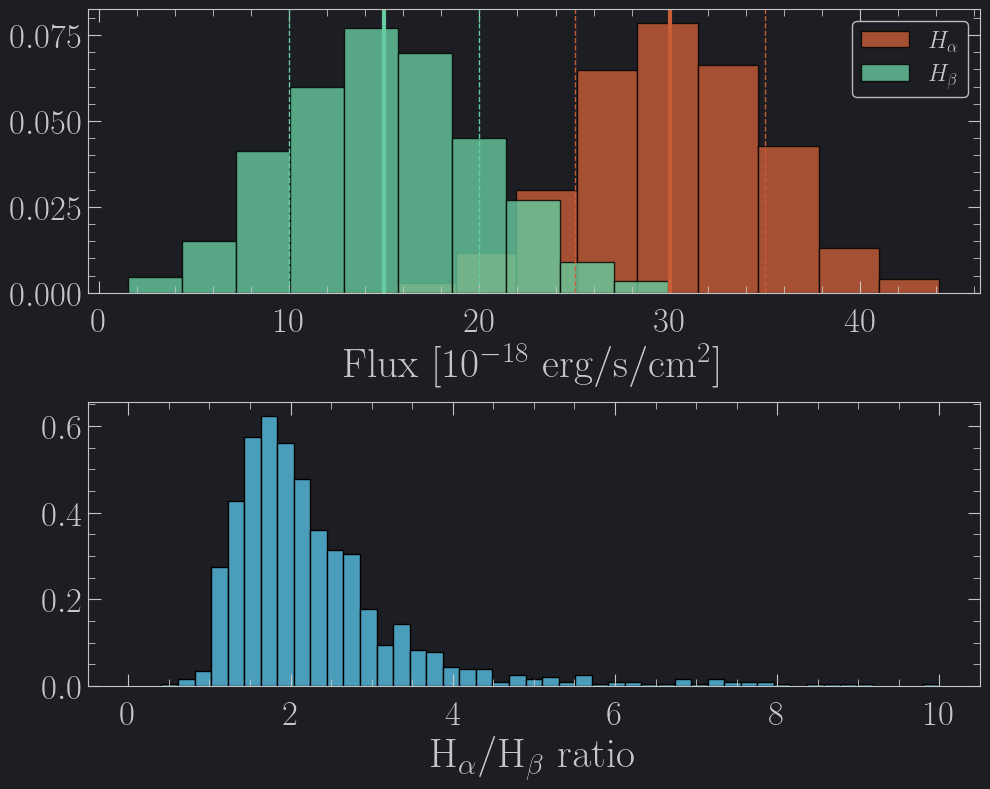

In [6]:
show_Ha_Hb(F_Ha, F_Ha_unc, F_Hb, F_Hb_unc, F_Ha_draw, F_Hb_draw)

## Avoiding unphysical values

In this example, the $H\beta$ line is detected only at 2 $\sigma$ with:

- $F_{H\beta} = (10 \pm 5) \times 10^{-18}$ erg/cm2/s

However, we know that the flux cannot be negative ; we can impose this in the sampling process by specifying the `val_min` argument.

In [7]:
F_Ha = 30.
F_Ha_unc = 5.
F_Hb = 10.
F_Hb_unc = 5.

F_Ha_draw = MC_realization(data=F_Ha,
                           uncp=F_Ha_unc)

F_Hb_draw = MC_realization(data=F_Hb,
                           uncp=F_Hb_unc,
                           val_min=0)

(-5.0, 50.0)

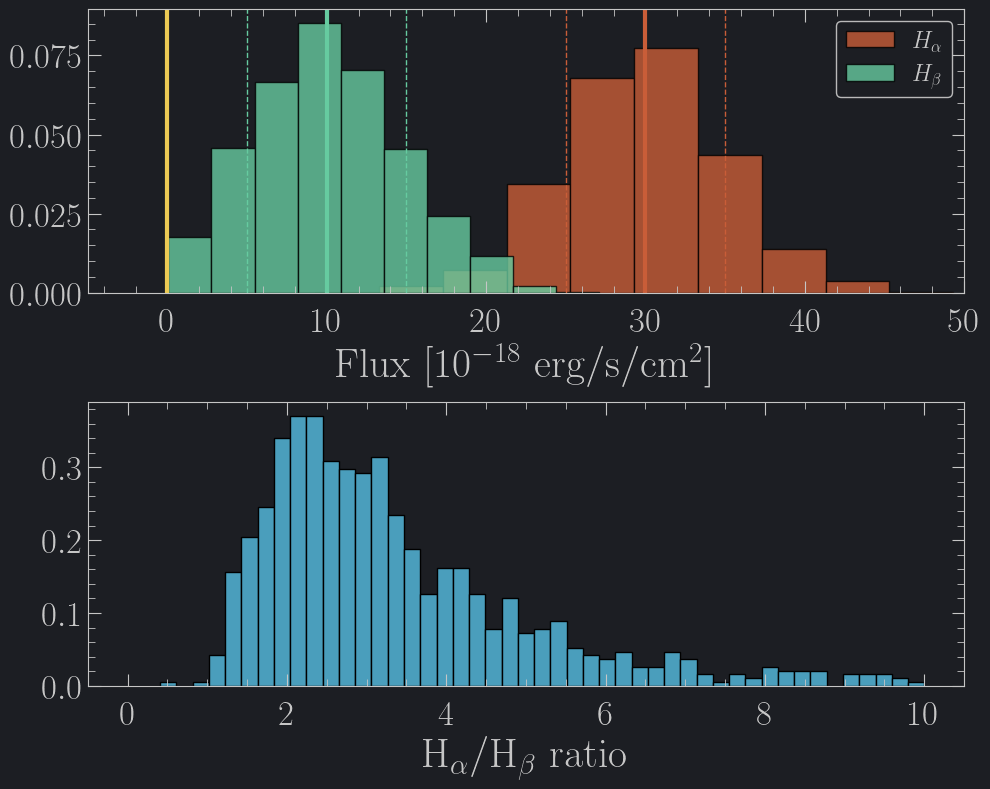

In [8]:
fig, axes = show_Ha_Hb(F_Ha, F_Ha_unc, F_Hb, F_Hb_unc, F_Ha_draw, F_Hb_draw)
axes[0].axvline(0)
axes[0].set_xlim(-5, 50)

## Asymmetric errors
If for some reason or another, you are dealing with asymmetric errors, this can be handled as well as shown in the following example:

In [9]:
F_Ha = 30.
F_Ha_uncp = 5.
F_Ha_uncm = 3.
F_Hb = 10.
F_Hb_uncp = 2.
F_Hb_uncm = 1.

F_Ha_draw = MC_realization(data=F_Ha,
                           uncp=F_Ha_uncp,
                           uncm=F_Ha_uncm)

F_Hb_draw = MC_realization(data=F_Hb,
                           uncp=F_Hb_uncp,
                           uncm=F_Hb_uncm)

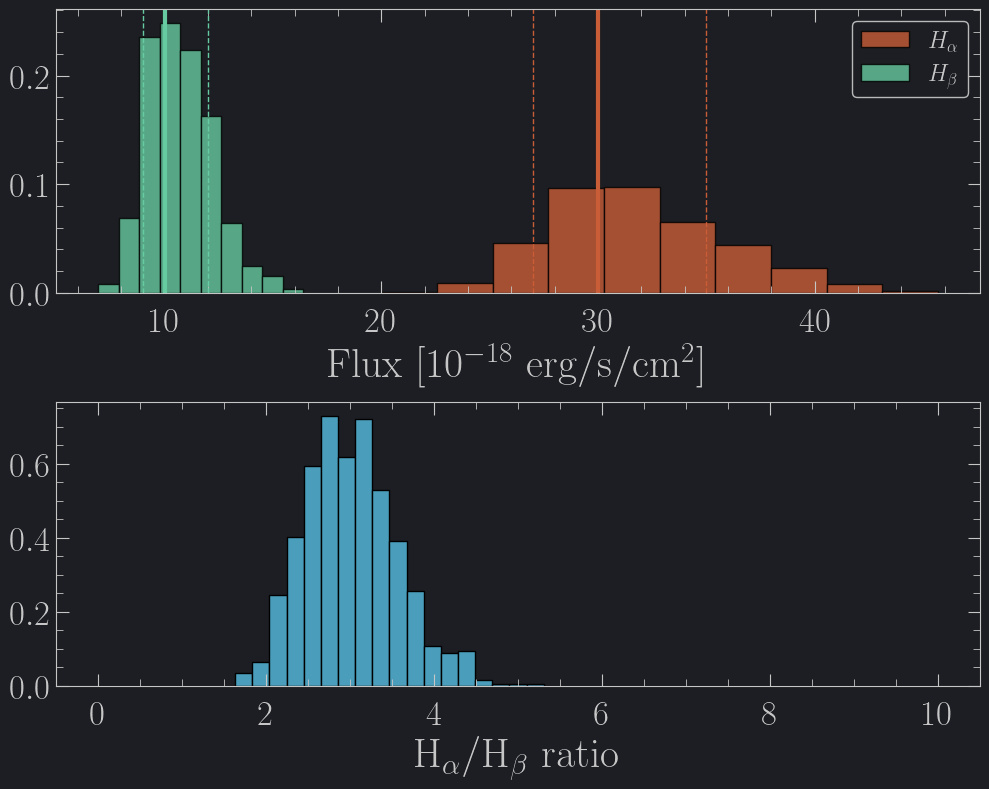

In [10]:
fig, axes = show_Ha_Hb(F_Ha=F_Ha,
                       F_Ha_uncp=F_Ha_uncp,
                       F_Hb=F_Hb,
                       F_Hb_uncp=F_Hb_uncp,
                       F_Ha_draw=F_Ha_draw,
                       F_Hb_draw=F_Hb_draw,
                       F_Ha_uncm=F_Ha_uncm,
                       F_Hb_uncm=F_Hb_uncm)

## Limits
Finally, if you have limits (in the case of non-detections for example), you may wish to sample uniformly between the limit as some minimum/maximum value.
The uniform sampling is based on the idea of minimum information: we know that the variable has _at least/most_ a certain value (the limit) and if we can a find reasonable maximum/minimum value, we can assume that the real value of the variable is somewhere between the limit and this maximum/minimum value.
Since we don't have more information, we assume conservatively that all values between these bounds are equiprobable (i.e. our variable follows a flat/uniform distributon).

###  Upper limit

In [11]:
F_Ha = 30.
F_Ha_max = 50.
F_Hb = 10.
F_Hb_uncp = 2.
F_Hb_uncm = 1.

logging.getLogger('astropalmerio.mc.realizations').setLevel('DEBUG')

F_Ha_draw = MC_realization(data=F_Ha,
                           lolim=True,
                           val_max=F_Ha_max)
F_Hb_draw = MC_realization(data=F_Hb,
                           uncp=F_Hb_uncp,
                           uncm=F_Hb_uncm)

2023-03-10 11:11:36,074 DEBUG [astropalmerio.mc.realizations] About to attempt sampling for following inputs:
data=30.0
uncp=None
uncm=None
lolim=True
uplim=False
val_min=None
val_max=50.0
N_MC=1000
2023-03-10 11:11:36,075 DEBUG [astropalmerio.mc.realizations] About to attempt sampling for following inputs:
data=10.0
uncp=2.0
uncm=1.0
lolim=False
uplim=False
val_min=None
val_max=None
N_MC=1000


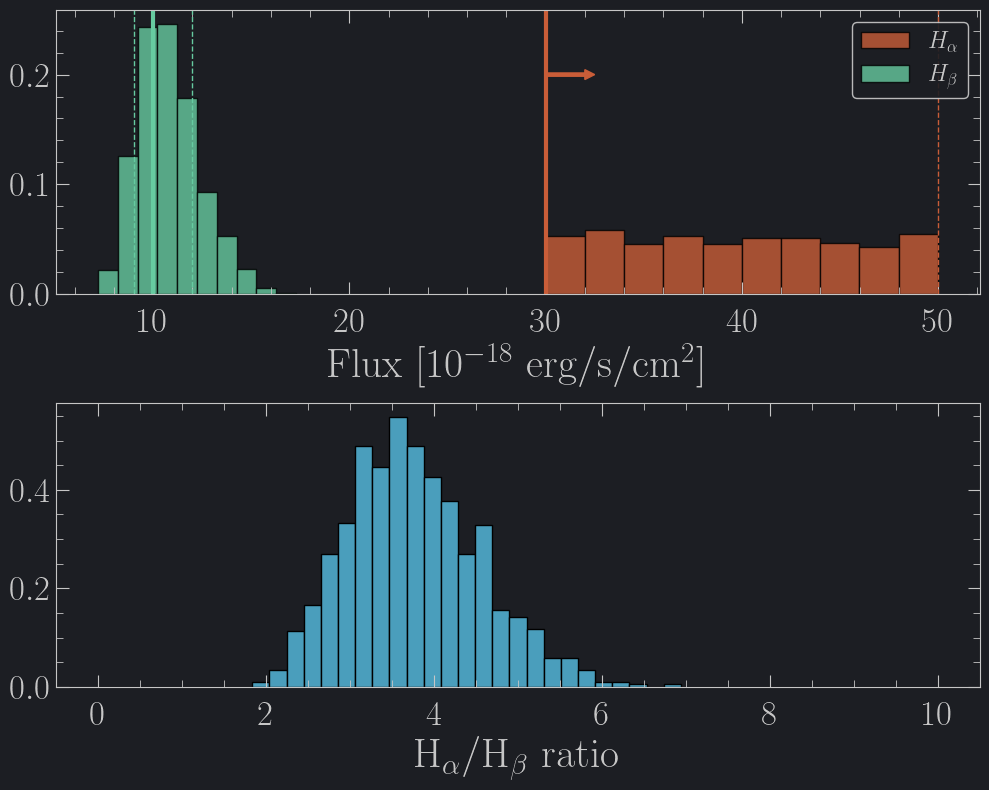

In [12]:
ratio = F_Ha_draw/F_Hb_draw
fig, axes = plt.subplots(2, tight_layout=True)
ax0 = axes[0]
ax1 = axes[1]
ax0.hist(F_Ha_draw, density=True, label=r'$H_\alpha$', alpha=0.8, color='C1')
ax0.axvline(F_Ha, color='C1')
ax0.axvline(F_Ha_max, ls='--', lw=1, color='C1')
ax0.arrow(x=F_Ha, y=0.2, dx=2, dy=0, width=0.003, head_length=0.5, color='C1')
ax0.hist(F_Hb_draw, density=True, label=r'$H_\beta$', alpha=0.8, color='C3')
ax0.axvline(F_Hb, color='C3')
ax0.axvline(F_Hb+F_Hb_uncp, ls='--', lw=1, color='C3')
ax0.axvline(F_Hb-F_Hb_uncm, ls='--', lw=1, color='C3')
ax0.set_xlabel(r'Flux [$\rm 10^{-18}~erg/s/cm^2$]')
ax1.set_xlabel(r'$\rm H_{\alpha}/H_{\beta}$ ratio')

ax0.legend()
ax1.hist(ratio, bins=np.linspace(0,10,50), density=True)
plt.show()

### Both upper and lower limits

In [13]:
F_Ha = 30.
F_Ha_max = 50.
F_Hb = 20.
F_Hb_min = 0.


F_Ha_draw = MC_realization(data=F_Ha,
                           lolim=True,
                           val_max=F_Ha_max)
F_Hb_draw = MC_realization(data=F_Hb,
                           uplim=True,
                           val_min=F_Hb_min)

2023-03-10 11:12:11,355 DEBUG [astropalmerio.mc.realizations] About to attempt sampling for following inputs:
data=30.0
uncp=None
uncm=None
lolim=True
uplim=False
val_min=None
val_max=50.0
N_MC=1000
2023-03-10 11:12:11,357 DEBUG [astropalmerio.mc.realizations] About to attempt sampling for following inputs:
data=20.0
uncp=None
uncm=None
lolim=False
uplim=True
val_min=0.0
val_max=None
N_MC=1000


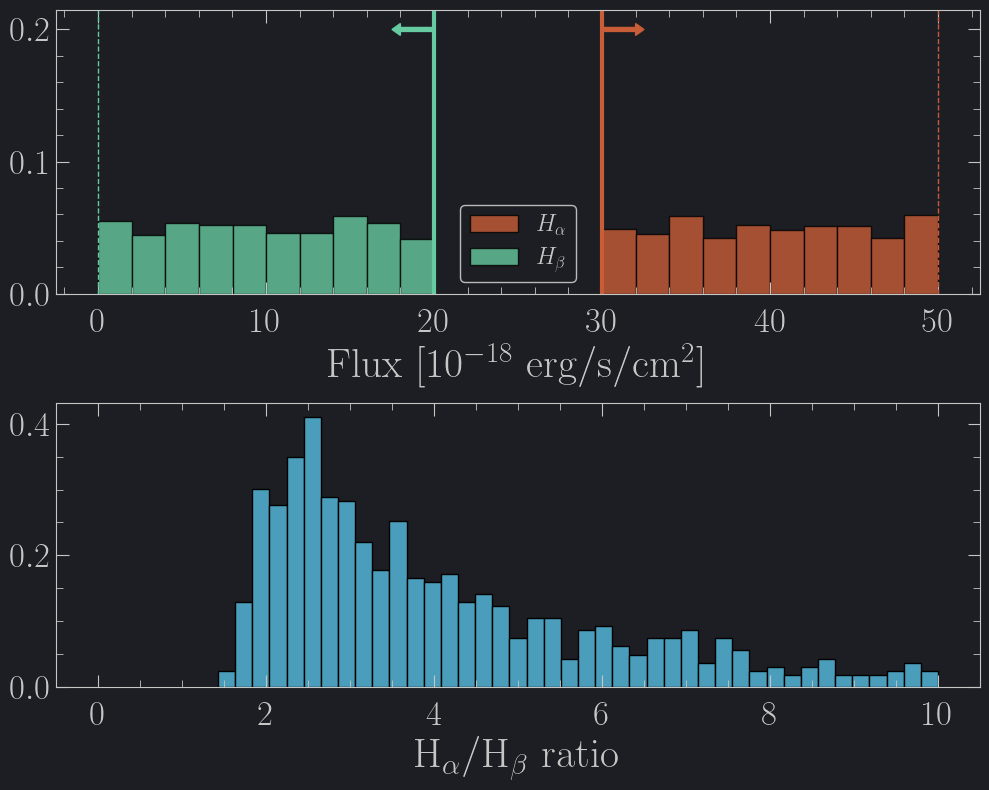

In [14]:
ratio = F_Ha_draw/F_Hb_draw
fig, axes = plt.subplots(2, tight_layout=True)
ax0 = axes[0]
ax1 = axes[1]
ax0.hist(F_Ha_draw, density=True, label=r'$H_\alpha$', alpha=0.8, color='C1')
ax0.axvline(F_Ha, color='C1')
ax0.axvline(F_Ha_max, ls='--', lw=1, color='C1')
ax0.arrow(x=F_Ha, y=0.2, dx=2, dy=0, width=0.003, head_length=0.5, color='C1')
ax0.hist(F_Hb_draw, density=True, label=r'$H_\beta$', alpha=0.8, color='C3')
ax0.axvline(F_Hb, color='C3')
ax0.axvline(F_Hb_min, ls='--', lw=1, color='C3')
ax0.arrow(x=F_Hb, y=0.2, dx=-2, dy=0, width=0.003, head_length=0.5, color='C3')
ax0.set_xlabel(r'Flux [$\rm 10^{-18}~erg/s/cm^2$]')
ax1.set_xlabel(r'$\rm H_{\alpha}/H_{\beta}$ ratio')

ax0.legend()
ax1.hist(ratio, bins=np.linspace(0,10,50), density=True)
plt.show()